# Research School:  Mathematics, Signal Processing and Learning
## January 25 - 29, 2021
## Signal Processing (N. Vayatis, L. Oudre)

<table border="0">
 <tr>
     <td><img src="affiche.png" style="height:500px;"></td>
     <td style="text-align:left">


1. [Introduction](#id1)
    1. Context
    2. Data
    3. Protocol
    4. Signals
    
    
2. [Data loading and first exploration](#id2)


3. [Study in the time-frequency domain](#id3)
    1. Notion of spectrogram
    2. Experiments
    3. Selection of the relevant frequency band
    
    
4. [Change-point detection](#id4)
    1. Problem statement
    2. Resolution
    3. Experiments in the time domain
    4. Experiments in the time-frequency domain
    

5. [Pattern extraction with convolutional dictionary learning](#id5)
    1. Problem statement
    2. Resolution
    3. Experiments
    

[<span style="color: red">Final project: computation of the walking speed and gait features</span>](#id6)

</td></tr></table>

## 1. Introduction <a class="anchor" id="id1"></a>

### A. Context

The study of human gait is a central problem in medical research with far-reaching consequences in the public health domain. This complex mechanism can be altered by a wide range of pathologies (such as Parkinson’s disease, arthritis, stroke,...), often resulting in a significant loss of autonomy and an increased risk of fall. Understanding the influence of such medical disorders on a subject's gait would greatly facilitate early detection and prevention of those possibly harmful situations. To address these issues, clinical and bio-mechanical researchers have worked to objectively quantify gait characteristics.

Among the gait features that have proved their relevance in a medical context, several are linked to the notion of step (step duration, variation in step length, etc.), which can be seen as the core atom of the locomotion process. Many algorithms have therefore been developed to automatically (or semi-automatically) detect gait events (such as heel-strikes, heel-off, etc.) from accelerometer/gyrometer signals.

Most of the time, the algorithms used for step detection are dedicated to a specific population (healthy subjects, elderly subjects, Parkinson patients, etc.) and only a few publications deal with heterogeneous populations composed of several types of subjects. Another limit to existing algorithms is that they often focus on locomotion in established regime (once the subject has initiated its gait) and do not deal with steps during U-turn, gait initiation or gait termination. Yet, initiation and termination steps are particularly sensitive to pathological states. For example, the first step of Parkinsonian patients has been described as slower and smaller that the first step of age-matched subjects. U-turn steps are also interesting since 45% of daily living walking is made up of turning steps, and when compared to straight-line walking, turning has been emphasized as a high-risk fall situation. This argues for reliable algorithms that could detect initiation, termination and turning steps in both healthy and pathological subjects.

### B. Data

The data was collected between April 2014 and October 2015 by monitoring healthy (control) subjects and patients from several medical departments (see publication for more information). Participants are divided into three groups depending on their impairment:

* Healthy subjects had no known medical impairment (labelled as "T" for Témoin).
* The orthopedic group is composed of 3 cohorts of distinct pathologies: lower limb osteoarthrosis (ArtH, ArtG), cruciate ligament injury (LCA), knee injury (Genou)
* The neurological group is composed of 2 cohorts: cerebellar disorder (CER) and radiation induced leukoencephalopathy (LER)

Note that certain participants were recorded on multiple occasions, therefore several trials may correspond to the same person. **In total we included 221 recordings for this tutorial session.** 

Indexes:
* ArtG : 121, 122
* ArtH : 27, 28
* CER : 116, 117, 118, 119, 120, 186, 187
* Genou : 150, 151
* LCA : 73, 74
* LER : 137, 138, 139, 140, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220

### C. Protocol

All subjects underwent the same protocol described below. First, a IMU (Inertial Measurement Unit) that recorded angular velocities was attached to the dorsal face of each foot. All signals have been acquired at 100 Hz with XSens sensors. After sensor fixation, participants were asked to perform the following sequence of activities:

* stand for 6 s,
* walk 10 m at preferred walking speed on a level surface to a previously shown turn point,
* turn around (without previous specification of a turning side),
* walk back to the starting point,
* stand for 2 s.

Subjects walked at their comfortable speed with their shoes and without walking aid. 
This protocol is schematically illustrated in the following figure.

<img src="protocol-schema.png" style="height:200px;">

### D. Signals

Each IMU records its acceleration and angular velocity in the  $(X,Y,Z,V)$  set of axes defined in the following figure. The  $V$  axis is aligned with gravity, while the  $X$ ,  $Y$  and  $Z$  axes are attached to the sensor. **In this session, signals only consist of the angular velocity aroung axis $Y$**

<img src="sensor-photo.png" style="height:300px;">

## 2. Data loading and first exploration <a class="anchor" id="id2"></a>

In [14]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
import ruptures as rpt
from sporco.admm import cbpdn
from sporco.dictlrn import cbpdndl

In [15]:
plt.rcParams['figure.figsize'] = (10,5)

In [16]:
# Data loading
npzfile = np.load('DataTP.npz',allow_pickle=True)
X=npzfile['arr_0']
Fs=100

In [17]:
id_subject=0 # CHOOSE A RECORDING

# Load the recording
xL=X[id_subject]['left']
xR=X[id_subject]['right']
age=X[id_subject]['age']
label=X[id_subject]['label']

# Create a time vector
N=np.size(xL)
t=np.arange(N)/Fs

d=(N-1)/Fs

print("Age of the subject : {age} y.o.".format(**locals()))
print("Pathology : {label}".format(**locals()))
print("Duration of the recording : {d} seconds".format(**locals()))

Age of the subject : 18 y.o.
Pathology : T
Duration of the recording : 20.07 seconds


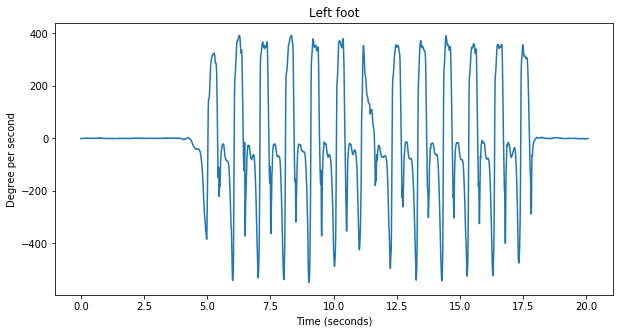

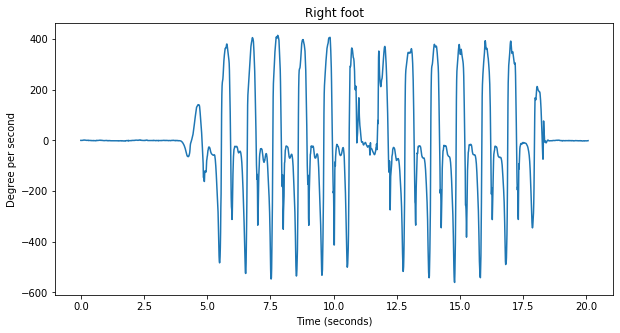

In [18]:
# Plot of the signals
plt.figure()
plt.plot(t,xL)
plt.ylabel('Degree per second')
plt.title('Left foot')
plt.xlabel('Time (seconds)')

plt.figure()
plt.plot(t,xR)
plt.ylabel('Degree per second')
plt.title('Right foot')
plt.xlabel('Time (seconds)')
plt.show()

<div style="text-align:center"><img src="quest.jpg" style="height:100px;"> <span style="color: red">What do you observe? What differences can you see between healthy and pathological subjects ? How can you interprete the different phases in the protocol? </span></div>

## 3. Study in the time-frequency domain <a class="anchor" id="id3"></a>

### A. Notion of spectrogram

Locomotion of healthy subjects is almost assimilable to a periodic phenomenon: it therefore makes sense to study it in the time-frequency domain. To that aim, we use the STFT (Short-Term Fourier Transform) which consists in computing Fourier transform on overlapping frames and display it in a matrix form.

<img src="stft.png" style="height:300px;">

We display the absolute square of the STFT, often referred to as a **spectrogram**. This representation requires the specification of several parameters:
* $N_w$: window length (in samples). Often taken as a power of 2 (for FFT) and linked to the desired frequency resolution. 
* $N_o$: overlap between two successive frames (in samples). Often taken as  50\% or 75\% of the window length and characterizes the time resolution (optimal when $N_o=N_w-1$) 
* $w$: analysis window (Hann, Hamming, Blackman...). Traditionally, in order to limit side effects, the signal frame is multiplied by an analysis window 

### B. Experiments

In [19]:
def my_spectrogram(x,Nw,No,Fs):
    f, t, Sxx = signal.stft(x, fs=Fs,nperseg=Nw, noverlap=No, nfft=4*Nw)
    return f,t,np.abs(Sxx)**2

In [20]:
def plot_spectrogram(f,t,Sxx,legend):
    plt.figure(figsize=(10,5))
    plt.pcolormesh(t, f, Sxx)
    plt.xlabel('Time (second)')
    plt.ylabel('Frequency (Hz)')
    plt.title(legend)
    plt.colorbar()
    plt.show()

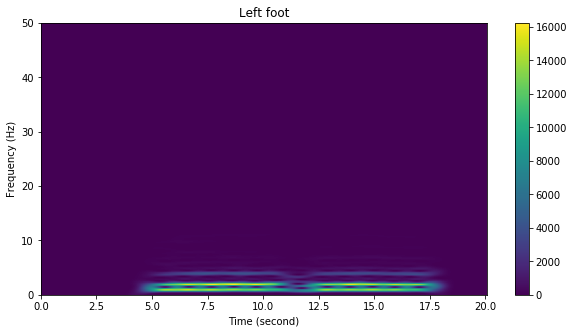

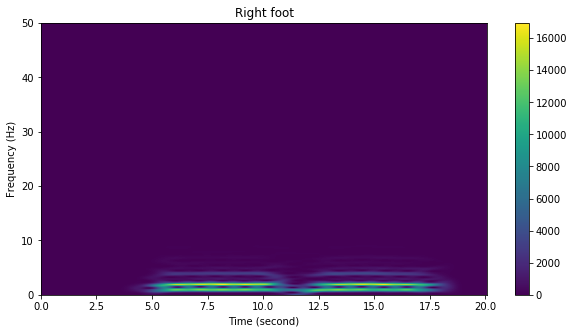

In [21]:
Nw=256 # Window length
No=255 # Overlap length
fL, tL, SxxL = my_spectrogram(xL,Nw,No,Fs)
fR, tR, SxxR = my_spectrogram(xR,Nw,No,Fs)

plot_spectrogram(fL,tL,SxxL,'Left foot')
plot_spectrogram(fR,tR,SxxR,'Right foot')

<div style="text-align:center"><img src="quest.jpg" style="height:100px;"> <span style="color: red">What do you observe? What differences can you see between healthy and pathological subjects ? Can you distinguish the different phases in the protocol?  What is the influence of the parameters? What frequency band is the most active during locomotion? </span></div>

### C. Selection of the relevant frequency band

As the sampling frequency of the signals is equal to 100 Hz (i.e. 100 samples per second), the sensor is able to record phenomenon up to 50 Hz (Nyquist frequency). However, as seen in the experiments, human locomotion does not involve such high frequencies: the aim of this section is to select the relevant frequency band to study locomotion.

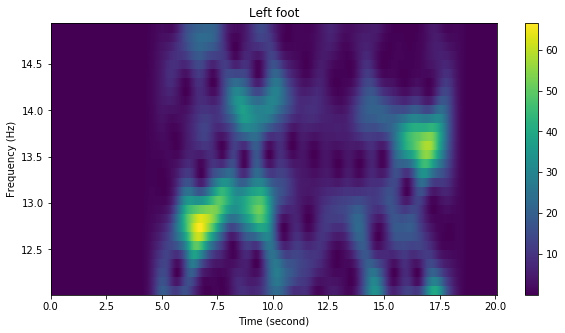

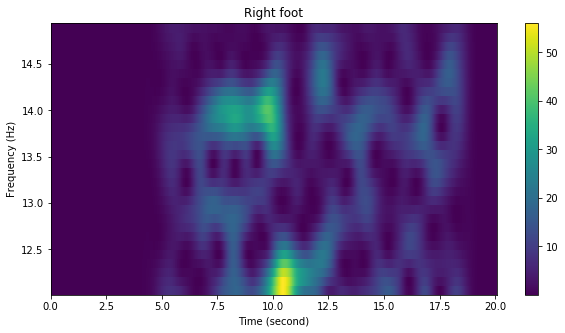

In [27]:
## Selection of the relevant frequency band

f_min=12 #CHANGE THESE FREQUENCIES
f_max=15 #CHANGE THESE FREQUENCIES

k=np.where((fL>=f_min) & (fL<=f_max))
SxxL2 = SxxL[k[0],:]
SxxR2 = SxxR[k[0],:]
fL2=fL[k[0]]
fR2=fR[k[0]]

plot_spectrogram(fL2,tL,SxxL2,'Left foot')
plot_spectrogram(fR2,tR,SxxR2,'Right foot')

## 4. Change-point detection <a class="anchor" id="id4"></a>

### A. Problem statement

In order to retrieve the different regimes in the data, we propose to explore change-point detection methods. Let assume that signal $x[n]$ undergoes abrupt changes at times $$\mathcal{T}^* = \left( t^*_1, \ldots, t^*_{K^*}\right) $$ Our goal is to retrieve the number of change-points and $K^*$ and their times $\mathcal{T}^*$. Here, since we know the protocol, we know that there should be 5 regimes (stop, walk, U-turn, walk, stop) so $K=4$ change points. The problem therefore rewrites as

<img src="ruptures.png" style="height:400px;">

$$\left( \hat{t}_1, \ldots, \hat{t}_{K}\right)  = \underset{\left( t_1, \ldots, t_{K}\right)}{\operatorname{argmin}} \sum_{k=0}^{K} \ c(x[t_{k}:t_{k+1}])$$

The most common cost function $c(.)$ is the L2-norm
$$c_{L_2}(x[a:b]) = \sum_{n=a+1}^{b} \|x[n] - \mu_{a:b} \|^2_2$$
where $\mu_{a:b}$ is the empirical mean of the segment $x[a:b]$. It detects changes in mean of univariate or multivariate signals.  

### B. Resolution

The most standard algorithm to find an exact solution of this problem is based on **dynamic programming**. By  denoting
  $$\mathcal{V}(\mathcal{T},\mathbf{x}) = \sum_{k=0}^{K} \ c(x[t_{k}:t_{k+1}])$$
  we can see that 
  \begin{eqnarray*}
		\min_{|\mathcal{T}|=K}\ V(\mathcal{T}, \mathbf{x} ) &=& \min_{0=t_0<t_1<\dots<t_K<t_{K+1}=N}\ \sum_{k=0}^{K} \ c(x[t_{k}:t_{k+1}]) \\
		&=& \min_{t\leq T-K} \ \bigg[ c(x[0:t])\ +\ \min_{t_0=t<t_1<\dots<t_{K-1}<t_{K}=T} \sum_{k=0}^{K-1} \ c(x[t_{k}:t_{k+1}]) \bigg] \\
		&=& \min_{t\leq T-K} \ \bigg[ c(x[0:t])\ +\ \min_{|\mathcal{T}|=K-1} V(\mathcal{T}, x[t:N] ) \bigg]
\end{eqnarray*}


This is a recursive problem that can be solved with dynamic programming. It consists of two steps:  computation of the cumulative costs + determination of the change-points. (see the [ruptures documentation](https://centre-borelli.github.io/ruptures-docs/) or [a recent review article](http://www.laurentoudre.fr/publis/TOG-SP-19.pdf) for more details). This algorithm has a complexity of  $\mathcal{O}(K N^2)$

### C. Experiments in the time domain

In this section, we will apply change-point detection methods with the L2-cost function, applied directly on the time signals.

In [23]:
def plot_ruptures_univariate(x,my_bkps,legend):
    rpt.show.display(x,  my_bkps, [], figsize=(10, 5))
    plt.ylabel('Degree per second')
    plt.title(legend)
    plt.xlabel('Samples')
    plt.show()

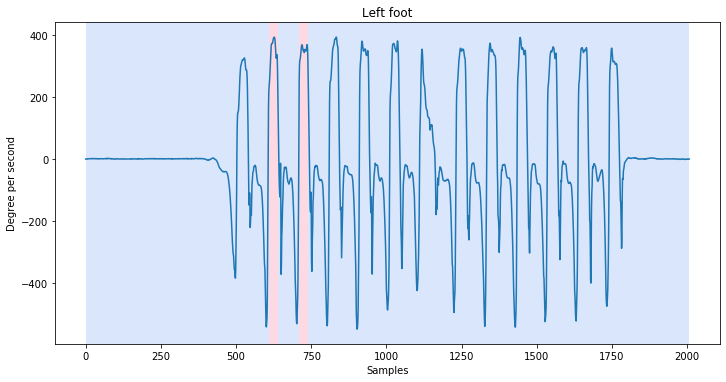

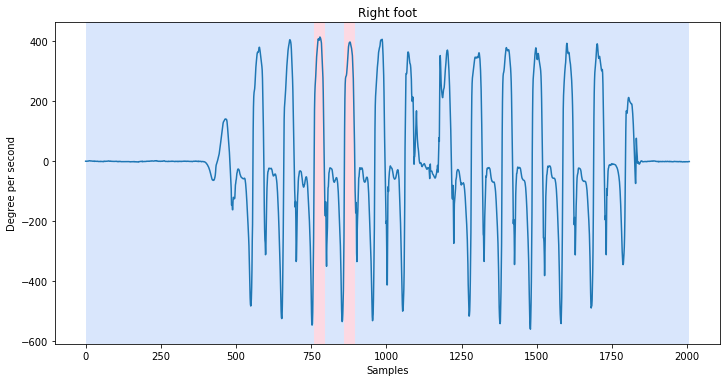

In [24]:
K=4 # Number of change-points
mod='l2' # Cost function

algoL = rpt.Dynp(model=mod, min_size=3).fit(xL)
algoR = rpt.Dynp(model=mod, min_size=3).fit(xR)
my_bkpsL = algoL.predict(n_bkps=K)
my_bkpsR = algoR.predict(n_bkps=K)

plot_ruptures_univariate(xL,my_bkpsL,'Left foot')
plot_ruptures_univariate(xR,my_bkpsR,'Right foot')

<div style="text-align:center"><img src="quest.jpg" style="height:100px;"><span style="color: red">What do you think of these results? Are you satisfied of the obtained segmentations?</span></div>

### D. Experiments in the time-frequency domain

In this section, we will apply change-point detection methods with the L2-cost function, but this time on the spectrograms, i.e. in the time-frequency domain.

In [25]:
def plot_ruptures_multivariate(f,t,Sxx,my_bkps,legend):
    plt.figure(figsize=(10,5))
    plt.pcolormesh(t, f, Sxx)
    for i in range(len(my_bkps)-1):
        plt.plot([t[my_bkps[i]],t[my_bkps[i]]],[f[0],f[-1]],'-w')
    plt.xlabel('Time (second)')
    plt.ylabel('Frequency (Hz)')
    plt.title(legend)
    plt.colorbar()
    plt.show()

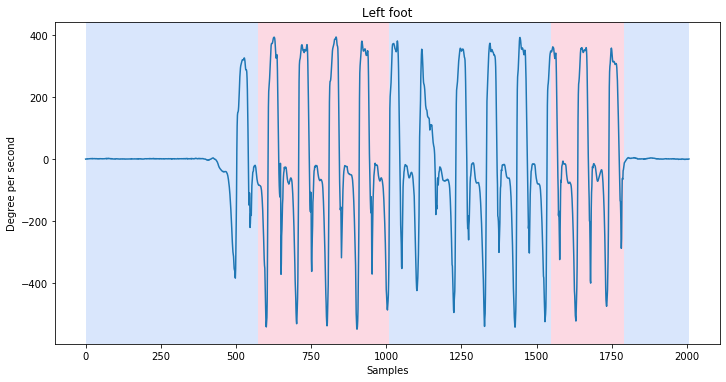

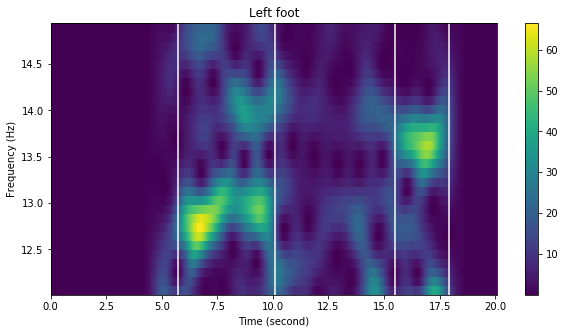

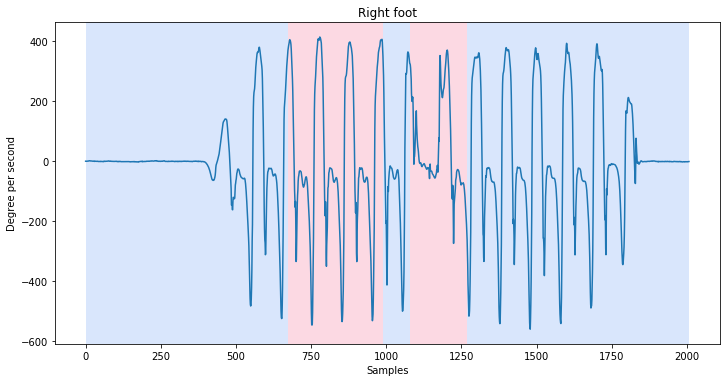

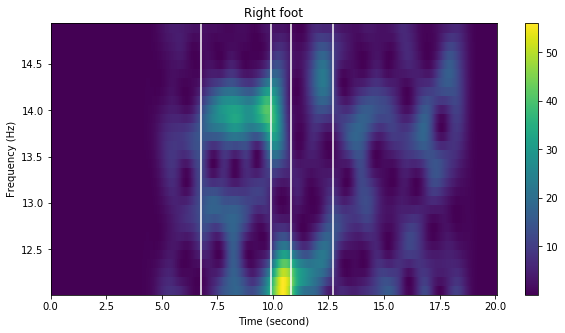

In [28]:
K=4 # Number of change-points
mod='l2' # Cost function

algoL = rpt.Dynp(model=mod, min_size=3).fit(np.transpose(SxxL2))
algoR = rpt.Dynp(model=mod, min_size=3).fit(np.transpose(SxxR2))
my_bkpsL = algoL.predict(n_bkps=K)
my_bkpsR = algoR.predict(n_bkps=K)

plot_ruptures_univariate(xL,my_bkpsL,'Left foot')
plot_ruptures_multivariate(fL2,tL,SxxL2,my_bkpsL,'Left foot')

plot_ruptures_univariate(xR,my_bkpsR,'Right foot')
plot_ruptures_multivariate(fR2,tR,SxxR2,my_bkpsR,'Right foot')

<div style="text-align:center"><img src="quest.jpg" style="height:100px;"><span style="color: red">What do you think of these results? Are you satisfied of the obtained segmentations? How does the algorithm behave on pathological subjects?</span></div>

## 5. Pattern extraction with convolutional dictionary learning <a class="anchor" id="id5"></a>

### A. Problem statement

Given a time series $x[n]$ composed of $N$ samples, **convolutional dictionary learning (CDL)** consists in decomposing the signal into
*  $K$ patterns (also called atoms) $\mathbf{d}_k$ of length $L$. Those represent local patterns that repetitively appear in the signal.
* $K$ activation signals $\mathbf{z}_k$ of length $N-L+1$. 
  $$z_k[n] \neq 0 \mbox{ if pattern }  \mathbf{d}_k \mbox{ is activated at time } n $$

<img src="convolu.png" style="height:400px;">

$$x[n] =  \sum_{k=1}^K (\mathbf{z}_k* \mathbf{d}_k)[n] +e[n]$$

Learning the patterns and the activations from the signal can be performed by solving the optimization problem 

$$\min_{\substack{(\mathbf{d}_k),(\mathbf{z}_k) \\ \forall k, \|\mathbf{d}_k\|_2^2\leq 1}}  \|\mathbf{x} - \sum_{k=1}^K \mathbf{z}_k* \mathbf{d}_k\|_2^2 + \lambda \sum_{k=1}^K \|\mathbf{z}_k\|_1$$

* **Normalization constraint** for the atoms $\mathbf{d}_k$, that prevents numerical instabilities (otherwise setting $\alpha \mathbf{d}_k$ and $\alpha^{-1} \mathbf{z}_k$ gives the same result)
* **Sparsity constraint** for the activations $\mathbf{z}_k$, that improves the interpretability of the learned patterns


### B. Resolution


This problem is not convex with respect to the couple $(\mathbf{d}_k),(\mathbf{z}_k)$ but convex when the subproblems are taken individually. The most common solution is therefore to alternately solve two subproblems:
* **Dictionary learning** 
$$\mathbf{D}^* = \underset{\substack{\mathbf{D}=(\mathbf{d}_1, \ldots, \mathbf{d}_K)\\ \forall k, \|\mathbf{d}_k\|_2^2\leq 1}}{\operatorname{argmin}}\|\mathbf{x} - \sum_{k=1}^K \mathbf{z}_k* \mathbf{d}_k\|_2^2$$
* **Convolutional sparse coding**
 $$\mathbf{Z}^* = \underset{\mathbf{Z}=(\mathbf{z}_1, \ldots, \mathbf{z}_K)}{\operatorname{argmin}}  \|\mathbf{x} - \sum_{k=1}^K \mathbf{z}_k * \mathbf{d}_k \|_2^2 + \lambda\sum_{k=1}^K \left\|\mathbf{z}_k\right\|_1$$
 
 In the following, both problems will be solved with ADMM (see the [SPORCO documentation](https://sporco.readthedocs.io/en/latest/modules/sporco.dictlrn.cbpdndl.html#sporco.dictlrn.cbpdndl.ConvBPDNDictLearn), [a recent review article](https://arxiv.org/pdf/1709.02893.pdf), or the optimization session for more details)

### C. Experiments

In [29]:
def convolutional_dictionary_learning(x,K,L,lmbda):
    N=np.size(x)
    y=(x-np.mean(x))/np.std(x) # z-score normalization
    X=np.reshape(y,(N,1))
    D=np.random.randn(L,1,K) # Random initilization for the atoms
    
    # Alternance between CDL and CSC steps to learn the dictionary
    opt = cbpdndl.ConvBPDNDictLearn.Options({'Verbose': False, 'MaxMainIter': 400,
                            'CBPDN': {'rho': 50.0*lmbda + 0.5},
                            'CCMOD': {'rho': 10.0}},
                            dmethod='cns')
    d = cbpdndl.ConvBPDNDictLearn(D, X, lmbda, opt, dmethod='cns')
    D = d.solve()
    
    # Final computation of the activation signals
    optSC = cbpdn.ConvBPDN.Options({'Verbose': False, 'MaxMainIter': 200,
                              'RelStopTol': 5e-3, 'AuxVarObj': False})    
    c = cbpdn.ConvBPDN(D, X, lmbda, optSC)
    Z = c.solve()
    
    D=D.squeeze()
    Z=Z.squeeze()
    return D,Z

In [30]:
def plot_CDL(x,Z,D):
    (L,K)=np.shape(D)
    plt.figure(figsize=(15,10))
    plt.subplot(K+1,3,(2,3))
    plt.plot(x)
    for i in range(K):
        plt.subplot(K+1,3,3*i+4)
        plt.plot(D[:,i])
        plt.subplot(K+1,3,(3*i+5,3*i+6))
        plt.plot(Z[:,i])
        plt.ylim((np.min(Z),np.max(Z)))

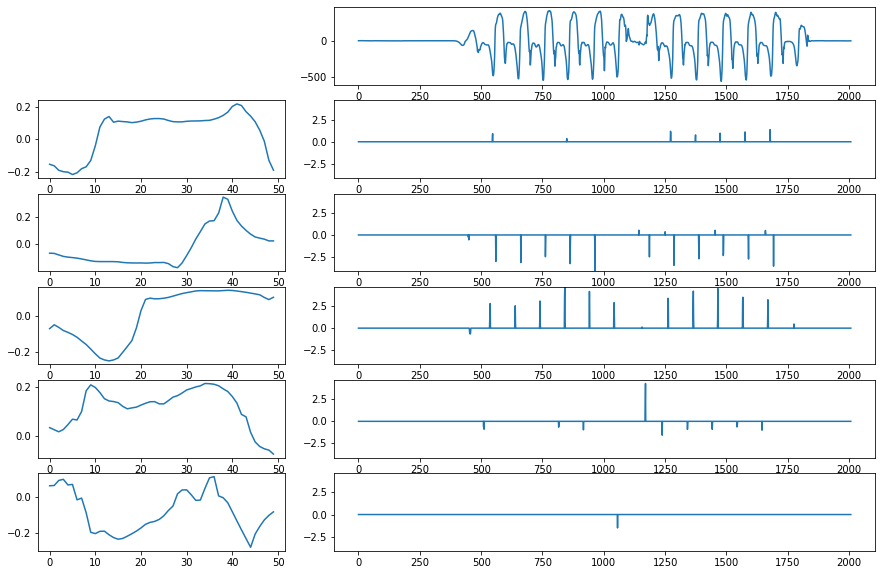

In [31]:
L=50 # CHANGE THE ATOM LENGTHS
K=5 # CHANGE THE NUMBER OF ATOMS
lmbda = 1
D,Z=convolutional_dictionary_learning(xR,K,L,lmbda)
plot_CDL(xR,Z,D)

<div style="text-align:center"><img src="quest.jpg" style="height:100px;"><span style="color: red">What do you think of these results? How does the algorithm behave on pathological subjects? What is the influence of parameters $\lambda$, $L$ and $K$? Propose a strategy for setting parameter $L$: what is its influence on the results?</span></div>

---

## <span style="color: red">Final project: computation of the walking speed and gait features</span> <a class="anchor" id="id6"></a>

<div style="text-align:center"><img src="python.png" style="height:100px;"><span style="color: red">Using previously described techniques, propose an algorithm and a Python function to compute the average walking speed and the average cadence (number of steps per second)</span></div>

Hint: for the estimation of the cadence, you may want to use the notion of **autocorrelation function** estimated as $$\hat{\gamma}_x[m] = \frac{1}{N} \sum_{n=0}^{N-1} x[n]x[n+m]\mbox{ (biased)}\ \ \ \ \mbox{where } x[n]=0 \mbox{ for } n \neq 0\ldots N-1$$
For a periodic signal, it will display peaks at multiple of the fundamental period $M_0$. See below for a practical usecase.

In [6]:
# Biased estimator of the autocorrelation function
# lags are comprised between -maxLags and +maxLags
def autocorrelation(x,maxLags):
    N=len(x)
    gammax=np.correlate(x,x,'full')/N
    lags=np.arange(0,maxLags+1)
    gammax=gammax[N-1:N+maxLags]
    return gammax,lags

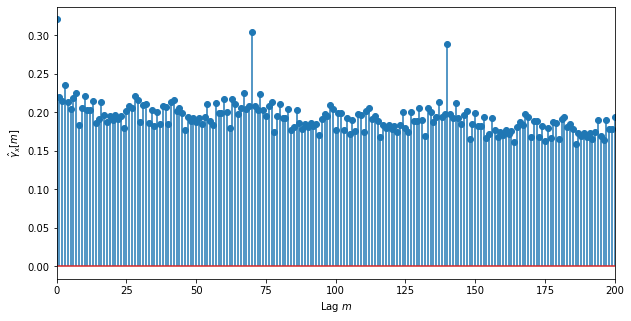

Largest value : 0.3207473590528443 for m=0
Second largest value : 0.3047099911002021 for m=70


In [7]:
# Create a periodic signal with fundamental period M0=70
M0=70
yT=np.random.rand(M0,)
y=np.tile(yT,20)

# Plot the autocorrelation function
maxLags=200
gammax,lags=autocorrelation(y,maxLags)
plt.stem(lags,gammax,use_line_collection=True)
plt.xlabel('Lag $m$')
plt.xlim((0,maxLags))
plt.ylabel('$\hat{\gamma}_x[m]$')
plt.show()

# Determination of the largest values
k=np.argsort(gammax)
print("Largest value : {} for m={}".format(gammax[k[-1]],lags[k[-1]]))
print("Second largest value : {} for m={}".format(gammax[k[-2]],lags[k[-2]]))